# Initial Steps


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset, ConcatDataset
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np
import os
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
###############################
###### Hyperparameters ########
###############################
# These are just base ones, we will change them to see the effect
num_clients = 20        # clients in total
communication_rounds = 60
K = 4                   # randomly pick 3 clients each round
local_epochs = 1
batch_size = 64
nz = 100
log_level = "error"
#############################

**Data Splitting:**

First Let's split data among users according to the iid/non-iid strategy

In [3]:
# First let's load and prepare MNIST
transform = transforms.Compose([
    transforms.Resize(64), # to conform DCGAN arch.
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)), # to [-1,1]
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# Combining both datasets
full_dataset = ConcatDataset([train_dataset, test_dataset])  # 70,000 samples but for now let's just use train_dataset as we may need test data for evaluation metrics

def split_data(num_clients=10):
    # Shuffle the entire dataset indices --> IID data
    indices = list(range(len(train_dataset)))
    random.shuffle(indices)
    total_size = len(train_dataset)
    size_per_client = total_size // num_clients

    train_datasets = []
    idx_ptr = 0
    for i in range(num_clients):  # Split into clients
        subset_indices = indices[idx_ptr : idx_ptr + size_per_client]
        idx_ptr += size_per_client
        subset_ds = Subset(train_dataset, subset_indices)
        train_datasets.append(subset_ds)

    print(f"Number of clients: {num_clients}   Number of train samples per client: {size_per_client}")
    # Create Dataloaders
    client_loaders = []
    for ds in train_datasets:
        loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
        client_loaders.append(loader)
    return client_loaders # list of train loaders of clients


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 461kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.26MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.21MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



**Conditional DCGAN:**

First Let's define Conditional generator and discriminator based on DCGAN architecture.

In [4]:

########## Conditional DCGAN Models ###########
class cDCGenerator(nn.Module):
    """
      - n_classes: 10 for MNIST  nz: dimension of noise vector  nc: 1 for MNIST
      - Architecture (64×64): - Input is (nz + n_classes) channels in a (batch_size, nz+n_classes, 1, 1) shape - Output is (batch_size, nc, 64, 64)
    """
    def __init__(self, n_classes=10, nz=100, ngf=64, nc=1):
        super().__init__()
        self.n_classes = n_classes
        self.nz = nz
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(nz + n_classes, ngf*8, 4, 1, 0, bias=False), nn.BatchNorm2d(ngf*8), nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False)         , nn.BatchNorm2d(ngf*4), nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False)         , nn.BatchNorm2d(ngf*2), nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False)           , nn.BatchNorm2d(ngf)  , nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_oh = self.label_emb(labels).unsqueeze(2).unsqueeze(3) # Reshape to (B, n_classes, 1, 1)
        x = torch.cat([z, label_oh], dim=1) # noise + label: shape => (B, nz+n_classes, 1, 1)
        return self.net(x)

class cDCDiscriminator(nn.Module):
    """
    label is embedded as one-hot, expanded spatially to 64×64, and concatenated with input image. So input to first conv layer = nc + n_classes
    """
    def __init__(self, n_classes=10, ndf=64, nc=1):
        super().__init__()
        self.n_classes = n_classes
        self.label_emb = nn.Embedding(n_classes, n_classes)

        self.main = nn.Sequential(

            nn.Conv2d(nc + n_classes, ndf, 4, 2, 1, bias=False), nn.LeakyReLU(0.2, inplace=True), # (nc + n_classes) x 64 x 64 # Not using BatchNorm in first layer of Discriminator (empirical)
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False)         , nn.BatchNorm2d(ndf*2), nn.LeakyReLU(0.2, inplace=True), # (ndf) x 32 x 32
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False)       , nn.BatchNorm2d(ndf*4), nn.LeakyReLU(0.2, inplace=True), # (ndf*2) x 16 x 16
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False)       , nn.BatchNorm2d(ndf*8), nn.LeakyReLU(0.2, inplace=True), # (ndf*4) x 8 x 8
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False), # (ndf*8) x 4 x 4
            nn.Sigmoid()  # output shape: (B, 1, 1, 1)
        )

    def forward(self, x, labels):  # x shape: (B, nc, 64, 64)  labels shape: (B,)
        label_oh = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        label_oh = label_oh.expand(-1, -1, x.size(2), x.size(3))
        inp = torch.cat([x, label_oh], dim=1) #  => (B, nc + n_classes, 64, 64)
        out = self.main(inp)
        return out


**Oracle MNIST Classifier:**

We need a good classifier on MNIST to calculate the evaluation metrics as suggested in the paper. This classifier has 99.6% accuracy just like the classifier used in the paper.

In [5]:

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(1024), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(1024 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.model(x)

mnist_classifier = MNIST_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mnist_classifier.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

def train_model(model, train_loader, test_loader, epochs=25):
    best_accuracy = 0.0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), "/content/best_mnist_classifier.pth") # for kaggle /kaggle/input/best_mnist_classifier.pth/pytorch/default/1/best_mnist_classifier.pth
    print(f"\n Training Complete! Best Test Accuracy: {best_accuracy:.2f}%")

if os.path.exists("/content/best_mnist_classifier.pth"):
    print("Model exists. Loading the pre-trained model.")
else:
    print("Model not found. Training the model...")
    train_model(mnist_classifier, train_loader, test_loader, epochs=25)

mnist_classifier.load_state_dict(torch.load("/content/best_mnist_classifier.pth", weights_only=True))
mnist_classifier.eval()

correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mnist_classifier(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_accuracy = 100 * correct / total
print(f" Final Test Accuracy: {final_accuracy:.2f}% ")


Model exists. Loading the pre-trained model.
 Final Test Accuracy: 99.60% 


**Classification Score:**

This score measures how much the predicted labels of generated samples agree with ground-truth labels under which the images where generated.

In [6]:
def compute_classification_score(generator, classifier, nz=100, num_samples=1000):
    """
    Evaluation metric as described in the paper
    """
    generator.eval().to(device)
    classifier.eval().to(device)
    fake_images, true_labels = generate_images(generator, nz=nz, num_samples=num_samples) # Generate images and corresponding labels
    fake_images = fake_images.to(device)
    with torch.no_grad():
        outputs = classifier(fake_images)
        predicted_labels = torch.argmax(outputs, dim=1)  # Get predicted labels
    # Compute accuracy
    accuracy = (predicted_labels.cpu() == true_labels).float().mean().item()
    return accuracy


# # Compute classification score
# classification_score = compute_classification_score(global_gen, mnist_classifier, nz=100, num_samples=1000)


**EMD Score:**

Earth Mover’s Distance (EMD) as described in the paper compares the softmax probabilities between real and generated images. (the less is better)


In [7]:

# Function to compute Earth Mover’s Distance (EMD)
def compute_emd(generator, classifier, real_loader, nz=100, num_samples=1000):

    generator.eval().to(device)
    classifier.eval().to(device)

    # Generate images using GAN
    fake_images, gen_labels = generate_images(generator, nz=nz, num_samples=num_samples)
    fake_images = fake_images.to(device)

    # Get real images
    real_images, real_labels = next(iter(real_loader))
    real_images, real_labels = real_images[:num_samples].to(device), real_labels[:num_samples].to(device)

    with torch.no_grad():
        real_probs = F.softmax(classifier(real_images), dim=1)  # Classifier probabilities for real images
        fake_probs = F.softmax(classifier(fake_images), dim=1)  # Classifier probabilities for generated images

    # Compute EMD using probability differences
    real_score = real_probs[torch.arange(num_samples), real_labels].mean().item()
    fake_score = fake_probs[torch.arange(num_samples), gen_labels].mean().item()

    emd_value = abs(real_score - fake_score)

    return emd_value


# Load real MNIST dataset
real_loader = DataLoader(test_dataset, batch_size=1000, shuffle=True)

# # Compute EMD
# emd_value = compute_emd(global_gen, mnist_classifier, real_loader, nz=100, num_samples=1000)

Utility function to generate images from trained gan generator

In [8]:
# Generating images using a trained generator
def generate_images(generator, nz=100, num_samples=100):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, nz, 1, 1, device=device)
        labels = torch.arange(num_samples, device=device) % 10 # labels from 0  to 9
        fake_images = generator(noise, labels).cpu()
    return fake_images, labels.cpu().numpy()


# Training

**Local GAN Training:**
Training clients models for local_epochs (E in FedAvg paper)

In [9]:
def local_cgan_training(disc, gen, dataloader, nz=100, lr=0.0002, betas=(0.5, 0.999), local_epochs=1):

    disc = disc.to(device)
    gen = gen.to(device)
    disc.train()
    gen.train()

    criterion = nn.BCELoss()
    optimizer_D = optim.Adam(disc.parameters(), lr=lr, betas=betas)
    optimizer_G = optim.Adam(gen.parameters(), lr=lr, betas=betas)

    total_loss = 0
    total_batches = 0

    for epoch in range(local_epochs):
        for real_imgs, labels in dataloader:
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)
            bs = real_imgs.size(0)

            valid = torch.ones(bs, device=device)
            fake = torch.zeros(bs, device=device)

            ### Train Discriminator ###
            optimizer_D.zero_grad()

            real_pred = disc(real_imgs, labels).view(-1)
            d_real_loss = criterion(real_pred, valid)

            z = torch.randn(bs, nz, 1, 1, device=device)
            fake_imgs = gen(z, labels)  # same labels
            fake_pred = disc(fake_imgs.detach(), labels).view(-1)
            d_fake_loss = criterion(fake_pred, fake)

            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            optimizer_D.step()

            ### Train Generator ###
            optimizer_G.zero_grad()
            fake_pred_g = disc(fake_imgs, labels).view(-1)
            g_loss = criterion(fake_pred_g, valid)
            g_loss.backward()
            optimizer_G.step()

            total_loss += d_loss.item()
            total_batches += 1
    avg_loss = total_loss / total_batches

    return disc, gen, avg_loss


**FedAvg:**

Averaging parameters of local model and updating global model.

In [10]:
def fed_avg(global_model, local_models):

    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.zeros_like(global_dict[k])

    for lm in local_models:
        for k, v in lm.state_dict().items():
            global_dict[k] += v

    # Average
    for k in global_dict.keys():
        global_dict[k] = global_dict[k] / len(local_models)

    global_model.load_state_dict(global_dict)


**Federated Training:**

Main training function to call local_cgan_training, update global models using fed_avg and sync local models.

This function is written by chatgpt. Custom synchronization strategy is that discriminator syncs every T steps with T linearly decaying from 6 to 1 and then stays at 1. generator syncs every step

In [19]:
def federated_cgan_training(global_disc, global_gen, rounds=5, K=3, num_clients=5, local_epochs=1, batch_size=64, nz=100, log_level="error"):
    # First let's prepare client dataloaders
    client_loaders = split_data(num_clients=num_clients)

    # Initializing and saving local models in a list. We use global model initial weights as suggested in FedAvg paper.
    local_discs = [cDCDiscriminator() for _ in range(num_clients)]
    local_gens = [cDCGenerator() for _ in range(num_clients)]
    for d, g in zip(local_discs, local_gens):
        d.load_state_dict(global_disc.state_dict())
        g.load_state_dict(global_gen.state_dict())

    # Dictionary to store client & round metrics
    training_metrics = {
        'clients': {client_id: {'losses': [], 'classification_scores': [], 'emd_scores': []} for client_id in range(num_clients)},
        'rounds': {'losses': [], 'classification_scores': [], 'emd_scores': []}
    }

    # Increasing strategy for discriminator sync interval T
    T_initial, T_final = 1, 8
    T_values = [min(T_final, round(T_initial + (T_final - T_initial) * (r / (rounds - 1)))) for r in range(rounds)]

    # # Decay strategy for discriminator sync interval T
    # T_initial, T_final = 8, 1
    # T_values = [max(T_final, round(T_initial - (T_initial - T_final) * (r / (rounds - 1)))) for r in range(rounds)]

    # Main loop
    for current_round in range(1, rounds + 1):  # Renamed 'round' to 'current_round'
        selected_clients = random.sample(range(num_clients), K)
        T = T_values[current_round - 1]  # Get current T value

        if log_level == "info":
            print(f"\n----------------- Federated Round {current_round}/{rounds} -----------------")
            print("              Selected clients:", selected_clients, f"Discriminator sync every {T} rounds")

        updated_discs = []
        updated_gens = []
        local_losses, local_classification_scores, local_emd_scores = [], [], []

        # Local training on selected clients
        for cidx in selected_clients:
            d_loc, g_loc, avg_loss = local_cgan_training(local_discs[cidx], local_gens[cidx], client_loaders[cidx], nz=nz, local_epochs=local_epochs)
            updated_discs.append(d_loc)
            updated_gens.append(g_loc)
            local_losses.append(avg_loss)
            training_metrics['clients'][cidx]['losses'].append((current_round, avg_loss))

            # Compute Classification Score for this client
            class_score = compute_classification_score(g_loc, mnist_classifier, nz=nz, num_samples=500)
            local_classification_scores.append(class_score)
            training_metrics['clients'][cidx]['classification_scores'].append((current_round, class_score))

            # Compute EMD for this client
            emd_score = compute_emd(g_loc, mnist_classifier, real_loader, nz=nz, num_samples=500)
            local_emd_scores.append(emd_score)
            training_metrics['clients'][cidx]['emd_scores'].append((current_round, emd_score))

        # Generator syncs every step
        fed_avg(global_gen, updated_gens)
        for i in range(num_clients):
            local_gens[i].load_state_dict(global_gen.state_dict())

        # Discriminator syncs every T rounds
        if current_round % T == 0:
            fed_avg(global_disc, updated_discs)
            for i in range(num_clients):
                local_discs[i].load_state_dict(global_disc.state_dict())

        # Calculate round-level aggregated scores
        round_loss = sum(local_losses) / len(local_losses)
        round_class_score = sum(local_classification_scores) / len(local_classification_scores)
        round_emd_score = sum(local_emd_scores) / len(local_emd_scores)

        training_metrics['rounds']['losses'].append((current_round, round_loss))
        training_metrics['rounds']['classification_scores'].append((current_round, round_class_score))
        training_metrics['rounds']['emd_scores'].append((current_round, round_emd_score))

        if log_level == "info":
            print(f"   Discriminator Loss: {round_loss:.2f}, Classification Score: {round_class_score:.2f}, EMD: {round_emd_score:.2f}")

    # Ensure final sync at the end
    fed_avg(global_disc, updated_discs)  # Always sync at the end for consistency
    print(f"Final Discriminator loss: {round_loss:.3f}, Classification Score: {round_class_score:.3f}, EMD: {round_emd_score:.3f}")

    return global_disc, global_gen, training_metrics


 <br>
Now just to show the correctness of federated learning let's perform training and evaluating the models in Sync D&G:

In [20]:
##### Federated Training #######
global_disc = cDCDiscriminator().to(device)
global_gen = cDCGenerator().to(device)

global_disc, global_gen, training_metrics = federated_cgan_training(
    global_disc, global_gen,
    rounds=communication_rounds,
    K=K,
    num_clients=num_clients,
    local_epochs=local_epochs,
    batch_size=batch_size,
    nz=nz,
    log_level="info"
)
print("\nFederated training completed.")


Number of clients: 20   Number of train samples per client: 3000

----------------- Federated Round 1/60 -----------------
              Selected clients: [17, 18, 16, 1] Discriminator sync every 1 rounds
   Discriminator Loss: 0.83, Classification Score: 0.10, EMD: 0.89

----------------- Federated Round 2/60 -----------------
              Selected clients: [11, 14, 5, 8] Discriminator sync every 1 rounds
   Discriminator Loss: 0.35, Classification Score: 0.17, EMD: 0.83

----------------- Federated Round 3/60 -----------------
              Selected clients: [6, 11, 17, 10] Discriminator sync every 1 rounds
   Discriminator Loss: 0.11, Classification Score: 0.24, EMD: 0.77

----------------- Federated Round 4/60 -----------------
              Selected clients: [0, 9, 12, 15] Discriminator sync every 1 rounds
   Discriminator Loss: 1.22, Classification Score: 0.48, EMD: 0.56

----------------- Federated Round 5/60 -----------------
              Selected clients: [17, 4, 14, 2] Disc

Now let's plot some images generated by this Sync_D&G Federated cGAN

In [21]:
# First Let's define some utility functions for plotting
def denormalize(tensor):
    return (tensor + 1) / 2

def plot_images_subplot(ax, images, labels, title):
    combined_image = []
    for digit in range(10):
        digit_images = images[labels == digit][:10]
        row_image = torch.cat([denormalize(img) for img in digit_images], dim=2)
        combined_image.append(row_image)
    combined_image = torch.cat(combined_image, dim=1)
    ax.imshow(combined_image.squeeze().numpy(), cmap="gray")
    ax.set_title(title, fontsize=14)
    ax.axis("off")

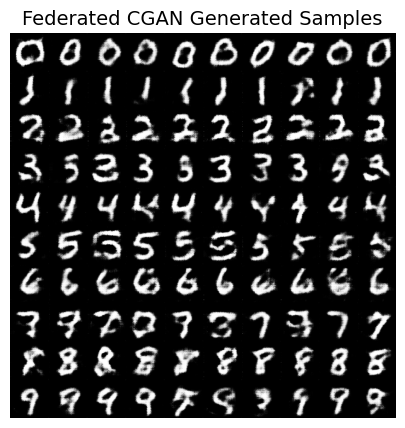

In [22]:
# Let's plot some generated images from federated cgan generator
generated_images, generated_labels = generate_images(global_gen, nz=nz, num_samples=100)

fig, ax = plt.subplots(figsize=(10, 5))
plot_images_subplot(ax, generated_images, generated_labels, "Federated CGAN Generated Samples")
plt.savefig('Federated_CGAN_Generated_Samples.png', dpi=1000, bbox_inches='tight')
plt.show()


**Scores per Round:**

Let's plot discriminator loss per round, classification score per round, EMD per round (solid lines) alongside individual client scores in dotted line.

In [23]:
def plot_training_metrics(training_metrics, clients_to_plot, rounds):

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Extract round-level data
    rounds_data = [entry[0] for entry in training_metrics['rounds']['losses']]
    round_losses = [entry[1] for entry in training_metrics['rounds']['losses']]
    round_class_scores = [entry[1] for entry in training_metrics['rounds']['classification_scores']]
    round_emd_scores = [entry[1] for entry in training_metrics['rounds']['emd_scores']]

    # Plot Round Losses
    axes[0].plot(rounds_data, round_losses, label='Avg Client Loss', linewidth=3, color='black')
    for client_id in clients_to_plot:
        client_data = training_metrics['clients'][client_id]['losses']
        rounds_client = [entry[0] for entry in client_data]
        losses = [entry[1] for entry in client_data]
        axes[0].plot(rounds_client, losses, linestyle='--', label=f'Client {client_id}')
    axes[0].set_xlabel('Round')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Client Loss per Round')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Classification Scores
    axes[1].plot(rounds_data, round_class_scores, label='Avg Classification Score', linewidth=3, color='blue')
    for client_id in clients_to_plot:
        client_data = training_metrics['clients'][client_id]['classification_scores']
        rounds_client = [entry[0] for entry in client_data]
        class_scores = [entry[1] for entry in client_data]
        axes[1].plot(rounds_client, class_scores, linestyle='--', label=f'Client {client_id}')
    axes[1].set_xlabel('Round')
    axes[1].set_ylabel('Score')
    axes[1].set_title('Classification Score per Round')
    axes[1].legend()
    axes[1].grid(True)

    # Plot EMD Scores
    axes[2].plot(rounds_data, round_emd_scores, label='Avg EMD Score', linewidth=3 , color='red')
    for client_id in clients_to_plot:
        client_data = training_metrics['clients'][client_id]['emd_scores']
        rounds_client = [entry[0] for entry in client_data]
        emd_scores = [entry[1] for entry in client_data]
        axes[2].plot(rounds_client, emd_scores, linestyle='--', label=f'Client {client_id}')
    axes[2].set_xlabel('Round')
    axes[2].set_ylabel('EMD')
    axes[2].set_title('Earth Mover’s Distance per Round')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.savefig('scores-per-round.png', dpi=1000, bbox_inches='tight')
    plt.show()

# Plot all metrics
clients_to_plot = list(range(5))  # Choose 10 clients to visualize

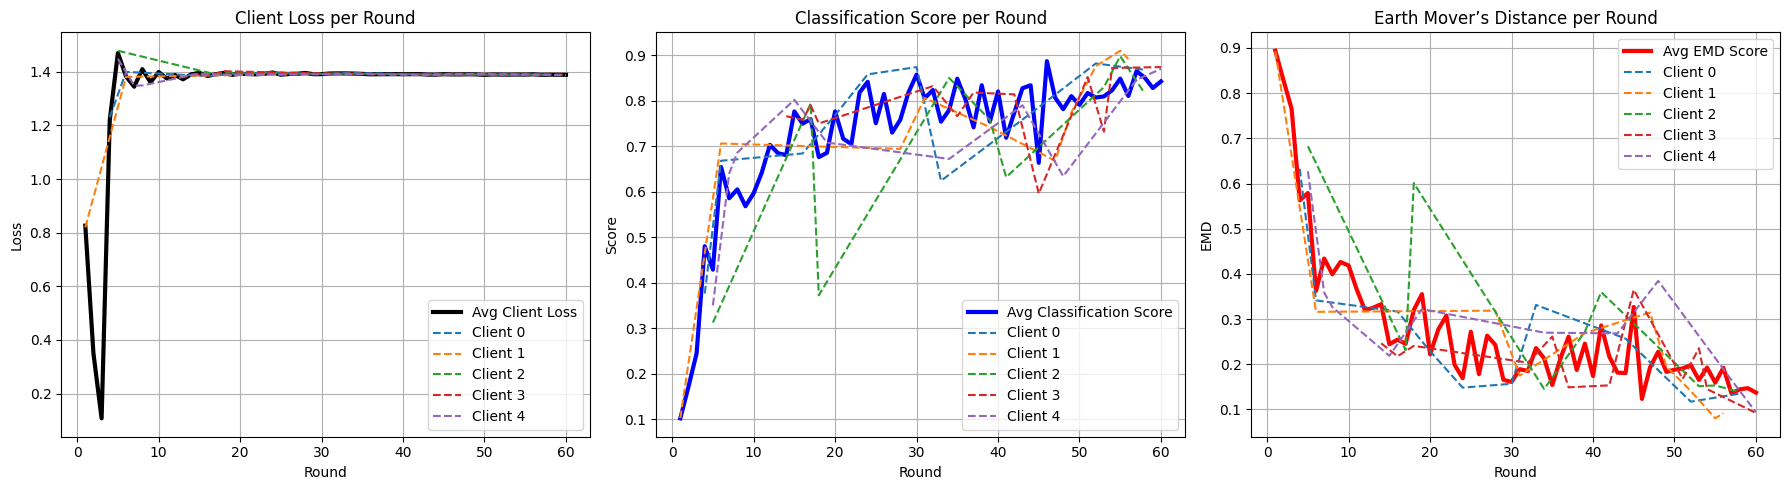

In [24]:
plot_training_metrics(training_metrics, clients_to_plot, 30)